In [1]:
#goal: provide basic implementation of deep learning NN for general application
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import tensorflow_probability as tfp
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
#import data set
import numpy as np
mnist = tf.keras.datasets.mnist
import random
from tensorboard.plugins.hparams import api as hp
import datetime
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
from sklearn import ensemble
from sklearn import linear_model
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
#import data set
import numpy as np
import random
from sklearn.model_selection import train_test_split
tfd = tfp.distributions


import matplotlib
%matplotlib inline
font = {        'size'   : 20}
matplotlib.rc('font', **font)

#gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
#   try:
#     tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
#   except RuntimeError as e:
#     # Visible devices must be set before GPUs have been initialized
#     print(e)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)
    

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


In [2]:

#import photoz data:
tfd = tfp.distributions
#from google.colab import files

photozdata = pd.read_csv('/data/HSC/HSC_IMAGES_FIXED/HSC_photozdata_full_header_trimmed.csv')
photozdata.replace(-99., np.nan, inplace=True)
photozdata.replace(-99.9, np.nan, inplace=True)

photozdata.replace(np.inf, np.nan, inplace=True)
spectro_z = np.asarray(photozdata["specz_redshift"])


col1 = np.asarray(photozdata["g_cmodel_mag"])
col2 = np.asarray(photozdata["r_cmodel_mag"])
col3 = np.asarray(photozdata["i_cmodel_mag"])
col4 =np.asarray(photozdata["z_cmodel_mag"])
col5 = np.asarray(photozdata["y_cmodel_mag"])

Text(0, 0.5, 'N Galaxies')

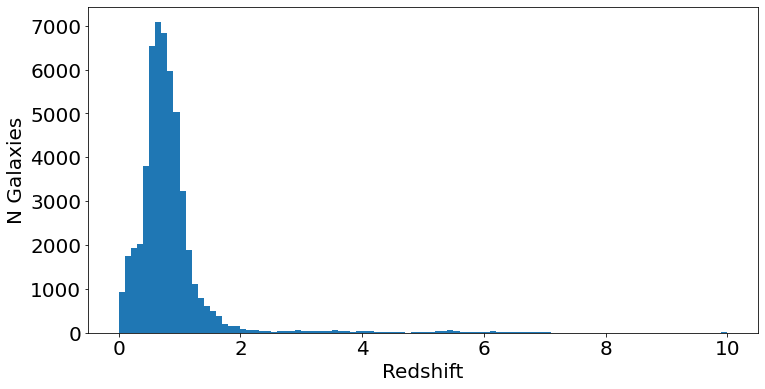

In [3]:
plt.figure(figsize=(12,6))
n,bins,patches = plt.hist(spectro_z,bins=100)
plt.xlabel('Redshift')
plt.ylabel('N Galaxies')

In [4]:
filt = (photozdata['specz_redshift'] < 9) & (photozdata['specz_redshift'] > 0) & (photozdata['specz_redshift_err'] >0) \
       & (photozdata['specz_redshift_err'] < 1)
photozdata_subset = photozdata[filt]

In [4]:
#now cap the redshift at 4, limit the gals per redshift bin and re-try


filt = (photozdata['specz_redshift'] < 4) & (photozdata['specz_redshift'] > 0) & (photozdata['specz_redshift_err'] >0) \
       & (photozdata['specz_redshift_err'] < 1)
photozdata_subset = photozdata[filt]

#divide data into bins of redshift with maximum 1k gals per bin

#try redshift bin size .01
binned_data = pd.DataFrame().reindex_like(photozdata_subset)

bin_size = .05
z_range = 4
num_bins = int(z_range / bin_size)
count = 0
for i in range(0,num_bins):
    p = 0
    for j in range(0,len(photozdata_subset)):
                
                if p == 500:
                    print('filed z range ' , (bin_size * i))
                    break
            
            
                if (photozdata_subset['specz_redshift'].iloc[j] > (bin_size * i)):
                    if (photozdata_subset['specz_redshift'].iloc[j] < (bin_size * (i+1))):
                        p = p + 1
                        binned_data.iloc[count] = photozdata_subset.iloc[[j]]
                        count = count + 1
                    
binned_data_trimmed = binned_data.iloc[:count]                     

filed z range  0.1
filed z range  0.15000000000000002
filed z range  0.2
filed z range  0.25
filed z range  0.30000000000000004
filed z range  0.35000000000000003
filed z range  0.4
filed z range  0.45
filed z range  0.5
filed z range  0.55
filed z range  0.6000000000000001
filed z range  0.65
filed z range  0.7000000000000001
filed z range  0.75
filed z range  0.8
filed z range  0.8500000000000001
filed z range  0.9
filed z range  0.9500000000000001
filed z range  1.0
filed z range  1.05
filed z range  1.1
filed z range  1.1500000000000001
filed z range  1.2000000000000002
filed z range  1.25


In [5]:
binned_data_trimmed = binned_data.iloc[:count]

In [6]:
binned_data_trimmed

,object_id_1,ra,dec,coord,skymap_id,g_cmodel_mag,r_cmodel_mag,i_cmodel_mag,z_cmodel_mag,y_cmodel_mag,...,i_cmodel_magsigma,z_cmodel_magsigma,y_cmodel_magsigma,object_id_2,specz_redshift_err,specz_redshift,specz_mag_i,specz_name,specz_ra,specz_dec
0,3.641580e+16,32.089564,-6.423959,"12 '(173654.171875, 108888.984375, -23077.8...",82800005.0,21.831490,20.608124,19.798933,19.269886,19.225950,...,0.002399,0.003876,0.007578,3.641580e+16,0.000070,0.000380,19.32300,12 SDSS-DR12-1237679340567528210 Name: spec...,32.089576,-6.423954
1,3.747650e+16,31.077496,-4.887470,"497 '(176017.25, 106086.125, -17573.5625)' ...",85210506.0,21.186531,21.138721,21.219900,21.215544,21.142405,...,0.007710,0.016145,0.030908,3.747650e+16,0.000050,0.013410,20.39300,497 SDSS-DR12-1237679322859635200 Name: spe...,31.077673,-4.887608
2,3.643870e+16,38.502812,-6.025354,"597 '(160526.46875, 127701.3828125, -21651....",82850608.0,22.285011,20.920113,20.542997,19.785963,19.344154,...,0.003727,0.004717,0.008135,3.643870e+16,0.000090,0.000080,19.43100,597 SDSS-DR12-1237679340570345971 Name: spe...,38.502826,-6.025371
3,3.748480e+16,34.563852,-5.903591,"1591 '(168957.0625, 116398.4140625, -21215....",85230200.0,22.816456,22.036460,21.288858,21.022554,20.799652,...,0.004829,0.008894,0.016804,3.748480e+16,0.000017,0.000794,NaN,1591 SDSS-DR14-9406993344712646656 Name: sp...,34.563881,-5.903518
5,3.748460e+16,34.951507,-4.905927,"2725 '(168442.9375, 117732.6796875, -17639....",85230006.0,22.920021,21.609318,20.470549,19.828209,19.613096,...,0.003837,0.004602,0.008940,3.748460e+16,0.000013,0.003112,20.65932,2725 SDSS-DR14-9406968605701021696 Name: sp...,34.951404,-4.905690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16920,4.169360e+16,16.908239,0.810557,"23694 '(197328.59375, 59984.0078125, 2917.9...",94800104.0,22.877872,22.750742,22.575747,22.693172,21.950460,...,0.035787,0.075092,0.040965,4.169360e+16,0.001670,3.958450,22.03900,23694 SDSS-DR12-1237663204921573926 Name: s...,16.908503,0.810625
16921,4.208070e+16,147.188202,0.764466,"24556 '(-173340.859375, 111761.0859375, 275...",95680104.0,22.309647,20.980290,19.984371,19.614437,19.404736,...,0.001847,0.002365,0.004116,4.208070e+16,0.000860,3.979500,19.97700,24556 DEEP3-201701-12100945 Name: specz_nam...,147.188220,0.764452
16922,4.161920e+16,351.386671,-0.123160,"34816 '(203937.984375, -30891.25, -443.3750...",94630307.0,22.747961,22.187593,21.415432,21.063400,20.935053,...,0.004173,0.006409,0.007540,4.161920e+16,0.003106,3.965822,21.34273,34816 SDSS-DR14-9868643098195632128 Name: s...,351.386780,-0.123011
16923,4.271850e+16,1.768714,1.933688,"36607 '(206049.125, 6362.734375, 6959.95654...",97130202.0,23.325500,22.249653,21.199131,20.761482,20.456230,...,0.005846,0.009526,0.014681,4.271850e+16,0.000747,3.984297,20.56589,36607 SDSS-DR14-8841828699995086848 Name: s...,1.768714,1.933734


Text(0, 0.5, 'N Galaxies')

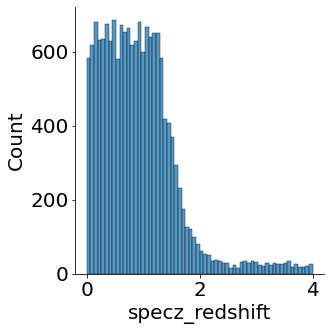

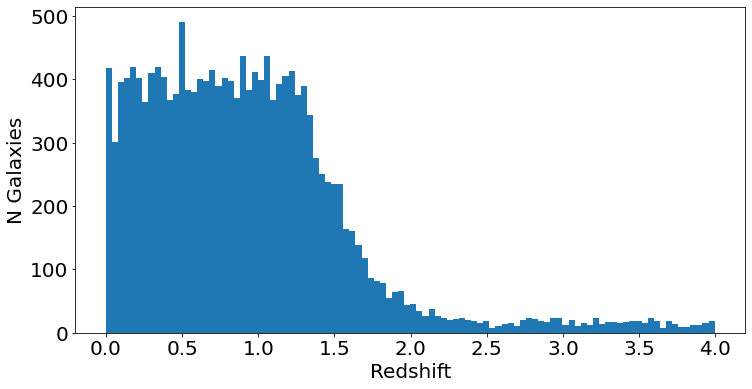

In [7]:
import seaborn as sns
ax = sns.displot(binned_data_trimmed.specz_redshift)

plt.figure(figsize=(12,6))
n,bins,patches = plt.hist(binned_data_trimmed.specz_redshift,bins=100)
plt.xlabel('Redshift')
plt.ylabel('N Galaxies')

In [11]:
test = pd.DataFrame().reindex_like(photozdata_subset)

In [14]:
bin_size = .01
z_range = 4
num_bins = z_range / bin_size

In [15]:
num_bins

400.0

In [20]:
photozdata_subset['specz_redshift'][6]

0.49694

In [45]:
binned_data = pd.DataFrame().reindex_like(photozdata_subset)

In [53]:
binned_data

,object_id_1,ra,dec,coord,skymap_id,g_cmodel_mag,r_cmodel_mag,i_cmodel_mag,z_cmodel_mag,y_cmodel_mag,...,i_cmodel_magsigma,z_cmodel_magsigma,y_cmodel_magsigma,object_id_2,specz_redshift_err,specz_redshift,specz_mag_i,specz_name,specz_ra,specz_dec
0,3.641580e+16,32.089564,-6.423959,"12 '(173654.171875, 108888.984375, -23077.8...",82800005.0,21.831490,20.608124,19.798933,19.269886,19.225950,...,0.002399,0.003876,0.007578,3.641580e+16,0.000070,0.000380,19.32300,12 SDSS-DR12-1237679340567528210 Name: spec...,32.089576,-6.423954
1,3.643870e+16,38.502812,-6.025354,"597 '(160526.46875, 127701.3828125, -21651....",82850608.0,22.285011,20.920113,20.542997,19.785963,19.344154,...,0.003727,0.004717,0.008135,3.643870e+16,0.000090,0.000080,19.43100,597 SDSS-DR12-1237679340570345971 Name: spe...,38.502826,-6.025371
2,3.748480e+16,34.563852,-5.903591,"1591 '(168957.0625, 116398.4140625, -21215....",85230200.0,22.816456,22.036460,21.288858,21.022554,20.799652,...,0.004829,0.008894,0.016804,3.748480e+16,0.000017,0.000794,NaN,1591 SDSS-DR14-9406993344712646656 Name: sp...,34.563881,-5.903518
3,3.748460e+16,34.951507,-4.905927,"2725 '(168442.9375, 117732.6796875, -17639....",85230006.0,22.920021,21.609318,20.470549,19.828209,19.613096,...,0.003837,0.004602,0.008940,3.748460e+16,0.000013,0.003112,20.65932,2725 SDSS-DR14-9406968605701021696 Name: sp...,34.951404,-4.905690
5,3.748480e+16,34.599143,-5.379053,"2760 '(169038.125, 116607.859375, -19336.15...",85230203.0,23.309807,21.661442,20.683907,20.218637,19.926850,...,0.003609,0.005288,0.009623,3.748480e+16,0.000072,0.000085,20.66563,2760 SDSS-DR14-9146897271522041856 Name: sp...,34.599252,-5.379041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52586,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 200)          1200        input_4[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 200)          40200       dense_7[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 200)          40200       dense_8[0][0]                    
____________________________________________________________________________________________

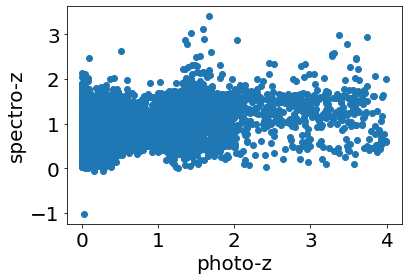

% correct:  0.09603841536614646
number of outliers:  2675  out of  8330
% of outliers:  32.11284513805522
number of catastrophic outliers:  161  out of  8330
% of catastrophic outliers:  0.019327731092436976
RMS error:  0.3061208061786727
RMS error =  0.5882330259804094


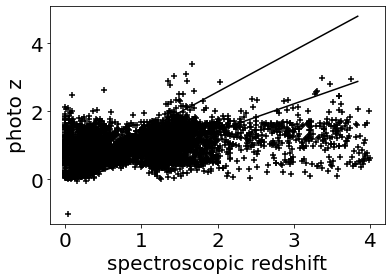

In [9]:


photozdata = binned_data_trimmed
spectro_z = np.asarray(photozdata["specz_redshift"])


col1 = np.asarray(photozdata["g_cmodel_mag"])
col2 = np.asarray(photozdata["r_cmodel_mag"])
col3 = np.asarray(photozdata["i_cmodel_mag"])
col4 =np.asarray(photozdata["z_cmodel_mag"])
col5 = np.asarray(photozdata["y_cmodel_mag"])

#scaled columns between 0 and 1
col1 /= np.max(np.abs(col1),axis=0)
col2 /= np.max(np.abs(col2),axis=0)
col3 /= np.max(np.abs(col3),axis=0)
col4 /= np.max(np.abs(col4),axis=0)
col5 /= np.max(np.abs(col5),axis=0)
#photodata = np.column_stack((col1,col2,col3,col4,col5))

photodata = {'col1':col1,
             'col2':col2,
             'col3':col3,
             'col4':col4,
             'col5':col5,
}

df = pd.DataFrame(photodata)
photodata = df

spectro_z = pd.DataFrame(spectro_z)

#bin the redshift:
bin_size = 0.1
#bin_size = 0.12
#bin the redshift:
bin_size = 0.05


x_train ,x_test,y_train,y_test = train_test_split(photodata,spectro_z,test_size=0.5)

y_train = np.array(y_train)
y_train = np.round(y_train/bin_size)
y_test = np.array(y_test)
y_test_original = y_test
y_test = np.round(y_test/bin_size)


x_train = np.array(x_train)

x_test = np.array(x_test)

#bin_size = 0.12
def random_gaussian_initializer(shape, dtype):
    n = int(shape / 2)
    loc_norm = tf.random_normal_initializer(mean=0., stddev=0.1)
    loc = tf.Variable(
        initial_value=loc_norm(shape=(n,), dtype=dtype)
    )
    scale_norm = tf.random_normal_initializer(mean=-3., stddev=0.1)
    scale = tf.Variable(
        initial_value=scale_norm(shape=(n,), dtype=dtype)
    )
    return tf.concat([loc, scale], 0)
def prior_trainable(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the prior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),  # Returns a trainable variable of shape n, regardless of input
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
    ])

def posterior_mean_field(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                       scale=1e-5 + 0.000001*tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
    ])


def prior_trainable(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the prior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),  # Returns a trainable variable of shape n, regardless of input
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
    ])

def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

#network architecture
#relu stands for rectified linear - modern standard for general application, I think
# model = tf.keras.Sequential([
#     #tf.keras.layers.Conv2D(40,(3,3),activation='relu',input_shape=(5,)),
#     tfp.layers.DenseVariational(320,activation='relu', input_shape=(10,),
#                                 make_posterior_fn=posterior_mean_field,
#                                 make_prior_fn=prior_trainable),
#     tf.keras.layers.Dense(160, activation='relu'),
#     tf.keras.layers.Dense(160, activation='relu'),
#     tf.keras.layers.Dense(80,activation='softmax'),
# ])

# model = tf.keras.Sequential([
#     #tf.keras.layers.Conv2D(40,(3,3),activation='relu',input_shape=(5,)),
#     tfp.layers.DenseVariational(320,activation='relu', input_shape=(10,),
#                                 make_posterior_fn=posterior_mean_field,
#                                 make_prior_fn=prior_trainable),
#     tf.keras.layers.Dense(160, activation='relu'),
#     tf.keras.layers.Dense(160, activation='relu'),
#     tf.keras.layers.Dense(80,activation='softmax'),
#     tf.keras.layers.Concatenate()(),
#     tf.keras.layers.Dense(1),
# ])

input_ = tf.keras.layers.Input(shape=x_train.shape[1:])
hidden1 = tfp.layers.DenseVariational(50, activation='relu', input_shape=(5,),
                                make_posterior_fn=posterior_mean_field,
                                make_prior_fn=prior_trainable)(input_)
hidden2 = tfp.layers.DenseVariational(50, activation='relu', input_shape=(5,),
                                make_posterior_fn=posterior_mean_field,
                                make_prior_fn=prior_trainable)(hidden1)
hidden3 = tfp.layers.DenseVariational(50, activation='relu', input_shape=(5,),
                                make_posterior_fn=posterior_mean_field,
                                make_prior_fn=prior_trainable)(hidden2)
hidden4 = tfp.layers.DenseVariational(50, activation='relu', input_shape=(5,),
                                make_posterior_fn=posterior_mean_field,
                                make_prior_fn=prior_trainable)(hidden3)
concat = tf.keras.layers.Concatenate()([input_, hidden4])
#output = tf.keras.layers.Dense(1)(concat)
distribution_params = tf.keras.layers.Dense(units=2)(concat)
output = tfp.layers.IndependentNormal(1)(distribution_params)
model = tf.keras.Model(inputs=[input_], outputs=[output])

input_ = tf.keras.layers.Input(shape=x_train.shape[1:])
hidden1 = tf.keras.layers.Dense(200, activation="relu")(input_)
hidden2 = tf.keras.layers.Dense(200, activation="relu")(hidden1)
hidden3 = tf.keras.layers.Dense(200, activation="relu")(hidden2)
hidden4 = tf.keras.layers.Dense(200, activation="relu")(hidden3)
concat = tf.keras.layers.Concatenate()([input_, hidden4])
output = tf.keras.layers.Dense(1)(concat)
model = tf.keras.Model(inputs=[input_], outputs=[output])


#note sure what these inputs mean. Find out.
#adam utilizes adaptive momentum - variant of stochasticc gradient descent.
#loss is the loss function

#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.compile(optimizer='adam', loss='mean_absolute_error',metrics=[tf.keras.metrics.MeanAbsoluteError()])

#model.compile(optimizer='adam', loss=negative_loglikelihood,metrics=[keras.metrics.RootMeanSquaredError()]

model.summary()

#history = model.fit(x_train,y_train,batch_size = 100, epochs=500,shuffle = True,verbose=1,validation_data=(x_test,y_test))
history = model.fit(x_train,y_train,batch_size=1000,epochs=5000,verbose=1,validation_data=(x_test,y_test))

# probability_model = tf.keras.Sequential([model,
#                                          tf.keras.layers.Softmax()])
#
# predictions = probability_model.predict(x_test)



predictions = model.predict(x_test)
np.argmax(predictions[0])
photoz = []
for i in range(0,len(y_test)):
    photoz.append(predictions[i]*bin_size)

plt.scatter(y_test_original,photoz)
#plt.title('Photo-z determination')
plt.ylabel('spectro-z')
plt.xlabel('photo-z')
plt.show()


# plt.scatter(y_test*bin_size,predictions*bin_size)
# plt.title('Photo-z determination')
# plt.ylabel('spectro-z')
# plt.xlabel('photo-z')
# plt.show()

#
# predictions_test = (model.predict(x_test) > 0.5).astype("int32")
# plt.scatter(y_test,predictions_test)
# plt.title('Photo-z determination')
# plt.ylabel('spectro-z')
# plt.xlabel('photo-z')
# plt.show()
#
#


# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train','Test'],loc='upper left')
# plt.show()

# print("Generate predictions for 3 samples")
# predictions = model.predict(x_test)
#
# plt.scatter(np.array(predictions),np.array(y_test))
# plt.show

# prediction = np.array(prediction)
# z = z[:,0]
#
# ############SHOW STATISTICS############
# err_abs = np.sum(abs(prediction - z)) / z.shape[0]
# deltaz = (prediction - z) / (1 + z)
# bias = np.sum(deltaz) / z.shape[0]
# nmad = 1.48 * np.median(abs(deltaz - np.median(deltaz)))
# print(" N = %d galaxies" %z.size)
# print(" bias = %.4g" %bias)
# print(" sigma_mad = %.4g" %nmad)


#calculate classification error and number of outliers and catastrophic outliers:

# for i = 0, test_set_length-1 do begin
# if output_integer[i] EQ test_target_rounded[i] then ++num_correct
# outliers[i] = (ABS(output[i] - testredshift[i])) / (1.0 + testredshift[i])
# if outliers[i] GT .15 then begin
# outlier_index_default[num_outliers_default + +] = i
# endif
# endfor

num_correct = 0
outliers = []
outlier_index = []
cat_outlier_index = []
#y_test = y_test * bin_size
for i in range(0,len(y_test)):

    if abs(photoz[i] - (y_test[i])*bin_size) < 0.0001:

        num_correct = num_correct + 1

    outliers.append(abs(photoz[i] - y_test_original[i])/(1+y_test_original[i]))

    if outliers[i] > 0.15:
            outlier_index.append(i)


    if outliers[i] > 1:
            cat_outlier_index.append(i)



print("% correct: ", 100.0*num_correct/len(y_test))
print("number of outliers: ", len(outlier_index), " out of ", len(y_test))
print("% of outliers: ", 100.0*len(outlier_index)/len(y_test))
print("number of catastrophic outliers: ", len(cat_outlier_index), " out of ", len(y_test))
print("% of catastrophic outliers: ", len(cat_outlier_index)/len(y_test))

#calculate RMS error:
RMS_error = np.sqrt(np.sum(((abs(photoz - y_test_original)/(1+y_test_original))**2))/len(y_test))
squares = [x*x for x in outliers]
RMS_error_2 = np.sqrt(np.sum(squares)/len(y_test))
print("RMS error: ", RMS_error_2)

#calculating RMSE another way:
RMSE = mean_squared_error(y_test_original,photoz, squared = False)
print("RMS error = ", RMSE)
# ;  if plot EQ 1 then begin
# ;    plot, temporary(testredshift), temporary(output), psym = 1, XRANGE = [0, 4], YRANGE = [0,
#                                                                                             4], title = 'Photo-z vs Spectro-z', xtitle = 'spectroscopic redshift', ytitle = 'photo-z'
# ;    PLOTS, [.18, 1.6 * 2], [0, 1.2 * 2]
# ;    PLOTS, [0, 1.6 * 2], [.15, 2 * 2]
# ;  endif


plt.scatter(y_test_original,photoz, marker='+',color = 'black')
#plt.title('Photo-z determination')
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([.18,1.6*2.4],[0,1.2*2.4], color='black')
plt.plot([0, 1.6 * 2.4], [.15, 2 * 2.4],color = 'black')
plt.show()


In [ ]:
#still terrible. now lets try bayesian model. if that doesnt work, limit # gals per bin to 500 and re-try

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_variational_4 (DenseVaria (None, 500)          9000        input_3[0][0]                    
__________________________________________________________________________________________________
dense_variational_5 (DenseVaria (None, 500)          751500      dense_variational_4[0][0]        
__________________________________________________________________________________________________
dense_variational_6 (DenseVaria (None, 500)          751500      dense_variational_5[0][0]        
____________________________________________________________________________________________

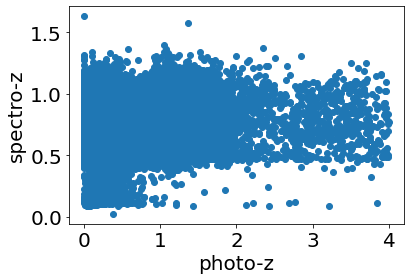

% correct:  0.0643915003219575
number of outliers:  9290  out of  40378
% of outliers:  23.007578384268662
number of catastrophic outliers:  51  out of  40378
% of catastrophic outliers:  0.0012630640447768586
RMS error:  0.18733274912898595
RMS error =  0.4278089377816488


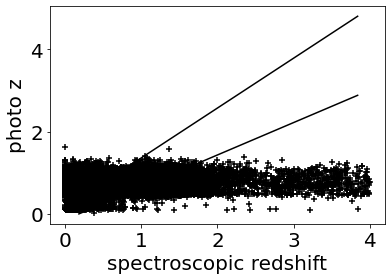

In [7]:
photozdata = binned_data_trimmed
spectro_z = np.asarray(photozdata["specz_redshift"])


col1 = np.asarray(photozdata["g_cmodel_mag"])
col2 = np.asarray(photozdata["r_cmodel_mag"])
col3 = np.asarray(photozdata["i_cmodel_mag"])
col4 =np.asarray(photozdata["z_cmodel_mag"])
col5 = np.asarray(photozdata["y_cmodel_mag"])

#scaled columns between 0 and 1
col1 /= np.max(np.abs(col1),axis=0)
col2 /= np.max(np.abs(col2),axis=0)
col3 /= np.max(np.abs(col3),axis=0)
col4 /= np.max(np.abs(col4),axis=0)
col5 /= np.max(np.abs(col5),axis=0)
#photodata = np.column_stack((col1,col2,col3,col4,col5))

photodata = {'col1':col1,
             'col2':col2,
             'col3':col3,
             'col4':col4,
             'col5':col5,
}

df = pd.DataFrame(photodata)
photodata = df

spectro_z = pd.DataFrame(spectro_z)

#bin the redshift:
bin_size = 0.1
#bin_size = 0.12
#bin the redshift:
bin_size = 0.01


x_train ,x_test,y_train,y_test = train_test_split(photodata,spectro_z,test_size=0.9)

y_train = np.array(y_train)
y_train = np.round(y_train/bin_size)
y_test = np.array(y_test)
y_test_original = y_test
y_test = np.round(y_test/bin_size)


x_train = np.array(x_train)

x_test = np.array(x_test)

#bin_size = 0.12
def random_gaussian_initializer(shape, dtype):
    n = int(shape / 2)
    loc_norm = tf.random_normal_initializer(mean=0., stddev=0.1)
    loc = tf.Variable(
        initial_value=loc_norm(shape=(n,), dtype=dtype)
    )
    scale_norm = tf.random_normal_initializer(mean=-3., stddev=0.1)
    scale = tf.Variable(
        initial_value=scale_norm(shape=(n,), dtype=dtype)
    )
    return tf.concat([loc, scale], 0)
def prior_trainable(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the prior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),  # Returns a trainable variable of shape n, regardless of input
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
    ])

def posterior_mean_field(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                       scale=1e-5 + 0.000001*tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
    ])


def prior_trainable(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the prior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),  # Returns a trainable variable of shape n, regardless of input
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
    ])

def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

#network architecture
#relu stands for rectified linear - modern standard for general application, I think
# model = tf.keras.Sequential([
#     #tf.keras.layers.Conv2D(40,(3,3),activation='relu',input_shape=(5,)),
#     tfp.layers.DenseVariational(320,activation='relu', input_shape=(10,),
#                                 make_posterior_fn=posterior_mean_field,
#                                 make_prior_fn=prior_trainable),
#     tf.keras.layers.Dense(160, activation='relu'),
#     tf.keras.layers.Dense(160, activation='relu'),
#     tf.keras.layers.Dense(80,activation='softmax'),
# ])

# model = tf.keras.Sequential([
#     #tf.keras.layers.Conv2D(40,(3,3),activation='relu',input_shape=(5,)),
#     tfp.layers.DenseVariational(320,activation='relu', input_shape=(10,),
#                                 make_posterior_fn=posterior_mean_field,
#                                 make_prior_fn=prior_trainable),
#     tf.keras.layers.Dense(160, activation='relu'),
#     tf.keras.layers.Dense(160, activation='relu'),
#     tf.keras.layers.Dense(80,activation='softmax'),
#     tf.keras.layers.Concatenate()(),
#     tf.keras.layers.Dense(1),
# ])

input_ = tf.keras.layers.Input(shape=x_train.shape[1:])
hidden1 = tfp.layers.DenseVariational(500, activation='relu', input_shape=(5,),
                                make_posterior_fn=posterior_mean_field,
                                make_prior_fn=prior_trainable)(input_)
hidden2 = tfp.layers.DenseVariational(500, activation='relu', input_shape=(5,),
                                make_posterior_fn=posterior_mean_field,
                                make_prior_fn=prior_trainable)(hidden1)
hidden3 = tfp.layers.DenseVariational(500, activation='relu', input_shape=(5,),
                                make_posterior_fn=posterior_mean_field,
                                make_prior_fn=prior_trainable)(hidden2)
hidden4 = tfp.layers.DenseVariational(500, activation='relu', input_shape=(5,),
                                make_posterior_fn=posterior_mean_field,
                                make_prior_fn=prior_trainable)(hidden3)
concat = tf.keras.layers.Concatenate()([input_, hidden4])
#output = tf.keras.layers.Dense(1)(concat)
distribution_params = tf.keras.layers.Dense(units=2)(concat)
output = tfp.layers.IndependentNormal(1)(distribution_params)
model = tf.keras.Model(inputs=[input_], outputs=[output])

# input_ = tf.keras.layers.Input(shape=x_train.shape[1:])
# hidden1 = tf.keras.layers.Dense(500, activation="relu")(input_)
# hidden2 = tf.keras.layers.Dense(500, activation="relu")(hidden1)
# hidden3 = tf.keras.layers.Dense(500, activation="relu")(hidden2)
# hidden4 = tf.keras.layers.Dense(500, activation="relu")(hidden3)
# concat = tf.keras.layers.Concatenate()([input_, hidden4])
# output = tf.keras.layers.Dense(1)(concat)
# model = tf.keras.Model(inputs=[input_], outputs=[output])


#note sure what these inputs mean. Find out.
#adam utilizes adaptive momentum - variant of stochasticc gradient descent.
#loss is the loss function

#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.compile(optimizer='adam', loss='mean_absolute_error',metrics=[tf.keras.metrics.MeanAbsoluteError()])

#model.compile(optimizer='adam', loss=negative_loglikelihood,metrics=[keras.metrics.RootMeanSquaredError()]

model.summary()

#history = model.fit(x_train,y_train,batch_size = 100, epochs=500,shuffle = True,verbose=1,validation_data=(x_test,y_test))
history = model.fit(x_train,y_train,batch_size=1000,epochs=2000,verbose=1,validation_data=(x_test,y_test))

# probability_model = tf.keras.Sequential([model,
#                                          tf.keras.layers.Softmax()])
#
# predictions = probability_model.predict(x_test)



predictions = model.predict(x_test)
np.argmax(predictions[0])
photoz = []
for i in range(0,len(y_test)):
    photoz.append(predictions[i]*bin_size)

plt.scatter(y_test_original,photoz)
#plt.title('Photo-z determination')
plt.ylabel('spectro-z')
plt.xlabel('photo-z')
plt.show()


# plt.scatter(y_test*bin_size,predictions*bin_size)
# plt.title('Photo-z determination')
# plt.ylabel('spectro-z')
# plt.xlabel('photo-z')
# plt.show()

#
# predictions_test = (model.predict(x_test) > 0.5).astype("int32")
# plt.scatter(y_test,predictions_test)
# plt.title('Photo-z determination')
# plt.ylabel('spectro-z')
# plt.xlabel('photo-z')
# plt.show()
#
#


# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train','Test'],loc='upper left')
# plt.show()

# print("Generate predictions for 3 samples")
# predictions = model.predict(x_test)
#
# plt.scatter(np.array(predictions),np.array(y_test))
# plt.show

# prediction = np.array(prediction)
# z = z[:,0]
#
# ############SHOW STATISTICS############
# err_abs = np.sum(abs(prediction - z)) / z.shape[0]
# deltaz = (prediction - z) / (1 + z)
# bias = np.sum(deltaz) / z.shape[0]
# nmad = 1.48 * np.median(abs(deltaz - np.median(deltaz)))
# print(" N = %d galaxies" %z.size)
# print(" bias = %.4g" %bias)
# print(" sigma_mad = %.4g" %nmad)


#calculate classification error and number of outliers and catastrophic outliers:

# for i = 0, test_set_length-1 do begin
# if output_integer[i] EQ test_target_rounded[i] then ++num_correct
# outliers[i] = (ABS(output[i] - testredshift[i])) / (1.0 + testredshift[i])
# if outliers[i] GT .15 then begin
# outlier_index_default[num_outliers_default + +] = i
# endif
# endfor

num_correct = 0
outliers = []
outlier_index = []
cat_outlier_index = []
#y_test = y_test * bin_size
for i in range(0,len(y_test)):

    if abs(photoz[i] - (y_test[i])*bin_size) < 0.0001:

        num_correct = num_correct + 1

    outliers.append(abs(photoz[i] - y_test_original[i])/(1+y_test_original[i]))

    if outliers[i] > 0.15:
            outlier_index.append(i)


    if outliers[i] > 1:
            cat_outlier_index.append(i)



print("% correct: ", 100.0*num_correct/len(y_test))
print("number of outliers: ", len(outlier_index), " out of ", len(y_test))
print("% of outliers: ", 100.0*len(outlier_index)/len(y_test))
print("number of catastrophic outliers: ", len(cat_outlier_index), " out of ", len(y_test))
print("% of catastrophic outliers: ", len(cat_outlier_index)/len(y_test))

#calculate RMS error:
RMS_error = np.sqrt(np.sum(((abs(photoz - y_test_original)/(1+y_test_original))**2))/len(y_test))
squares = [x*x for x in outliers]
RMS_error_2 = np.sqrt(np.sum(squares)/len(y_test))
print("RMS error: ", RMS_error_2)

#calculating RMSE another way:
RMSE = mean_squared_error(y_test_original,photoz, squared = False)
print("RMS error = ", RMSE)
# ;  if plot EQ 1 then begin
# ;    plot, temporary(testredshift), temporary(output), psym = 1, XRANGE = [0, 4], YRANGE = [0,
#                                                                                             4], title = 'Photo-z vs Spectro-z', xtitle = 'spectroscopic redshift', ytitle = 'photo-z'
# ;    PLOTS, [.18, 1.6 * 2], [0, 1.2 * 2]
# ;    PLOTS, [0, 1.6 * 2], [.15, 2 * 2]
# ;  endif


plt.scatter(y_test_original,photoz, marker='+',color = 'black')
#plt.title('Photo-z determination')
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([.18,1.6*2.4],[0,1.2*2.4], color='black')
plt.plot([0, 1.6 * 2.4], [.15, 2 * 2.4],color = 'black')
plt.show()
